In [2]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print
# tf.compat.v1.disable_eager_execution()

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization

from tensorflow.python.framework import ops

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [24]:
## these can also be globally set.
trial_seed = 1
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [4]:
m = models.load_model(FULL_MODEL_PATH)

Why do we have two functions named "grad_cam"? If one is just an example from elsewhere, please comment it out.

In [8]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In the `grad_cam` function, update all variable names.

In [25]:
def grad_cam(index): #rename to gradcam
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im") ## This is not being used right now
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_list = index

    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_list])])
    
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        print(loss_list)
#         print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear ## What does this do? put a note
        return model
    
    gradcam_images = validation_images[cam_list]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_images, penultimate_layer = -1) ## What does `penultimate_layer` do? Check github to see if option is still active
    cam = normalize(cam)
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_images ## update names to reflect reality; "gradcam_images" refers to a single image
    # end of function: return cam, gradcam_images

In [21]:
grad_cam([18])

Observed image class:  Improbable
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Shape of heatmap matrix: (1, 128, 128)


(array([[[0.3523436 , 0.35715353, 0.37049752, ..., 0.3297179 ,
          0.3142549 , 0.30863523],
         [0.35283014, 0.3578078 , 0.37160242, ..., 0.33422345,
          0.31919765, 0.31374148],
         [0.35434628, 0.35976917, 0.37476075, ..., 0.34634194,
          0.3324824 , 0.32746246],
         ...,
         [0.30239463, 0.30679592, 0.31874883, ..., 0.30688182,
          0.30136338, 0.2992739 ],
         [0.28432918, 0.28970447, 0.30430317, ..., 0.31400934,
          0.30946478, 0.30773497],
         [0.27761203, 0.28334716, 0.29892376, ..., 0.31666574,
          0.3124724 , 0.31087226]]], dtype=float32),
 array([[[[0.44313725],
          [0.57647059],
          [0.50588235],
          ...,
          [0.58431373],
          [0.58431373],
          [0.58431373]],
 
         [[0.50196078],
          [0.49411765],
          [0.58431373],
          ...,
          [0.59215686],
          [0.59215686],
          [0.57647059]],
 
         [[0.57254902],
          [0.4627451 ],
        

In [22]:
# Saving GCAM objects of validation images before disabling eager execution
gcam101 = grad_cam([101])
gcam18 = grad_cam([18])
gcam180 = grad_cam([180])
gcam212 = grad_cam([212])
gcam184 = grad_cam([184])

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 3.7088735 -3.9274487]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.7088735>]
Shape of heatmap matrix: (1, 128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-2.5035484  3.0303414]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.0303414>]
Shape of heatmap matrix: (1, 128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 3.6232486 -3.622695 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.6232486>]
Shape of heatmap matrix: (1, 128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-2.7449317  2.6163857]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.6163857>]
Shape of heatmap matrix: (1, 128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-4.864411  6.006728]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, 

In [23]:
# Save GCAM objects in a list to easily iterate over
gcam_list = [gcam101, gcam18, gcam180, gcam212, gcam184]

In [7]:
# Disable eager execution (GBP requirement)
# WARNING: kernel has to be restarted for GCAM to be called again.
# Replace Keras backed gradient with Gradient Tape for a permanent solution.
tf.compat.v1.disable_eager_execution()

def guided_backprop(index):#101
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    assert validation_labels[index].mean(axis=0)[0] == 0
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient():
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                    tf.cast(op.inputs[0] > 0., dtype)

    def modify_backprop(model, name, monochrome=True):
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            new_model = models.load_model(FULL_MODEL_PATH)
            
        return new_model

    def guided_backpropagation(img_tensor, model, activation_layer):
        model_input = model.input
        layer_output = model.get_layer(activation_layer).output

        max_output = K.max(layer_output, axis=3)

        get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        saliency = get_output([img_tensor])
        
        return saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
    
    return gradient, index

In [47]:
def guided_backprop_gt(index):#101
    ## Original implementation: https://gist.github.com/you359/d19449a1c64bb43519a11e5d9d430453
    training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    # assert validation_labels[index].mean(axis=0)[0] == 0 ## only makes sense for class 0 images; otherwise, assert validation_labels[index].mean(axis=0)[1]
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient(): ## modifies gradient to mask negative activations and gradients (guided signal)
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype) ## See Fig1c of Springenberg et al., 2015 (p. 8)

    def modify_backprop(model, name, monochrome=True): 
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}): ## update activation of ReLu
            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu
            # re-instantiate a new model
            new_model = models.load_model(FULL_MODEL_PATH)            
        return new_model

    #normalize saliency
    def guided_backpropagation(input_image, model, activation_layer):
        model_input = model.input
        print(model_input.shape)
        layer_output = model.get_layer(activation_layer).output
        print("Layer output shape: ", layer_output.shape)
        max_output = K.max(layer_output, axis=3) ## gets activation in layer of interest with greatest outputs (this what guided backprop does)
            ## in gbp, we visualize the part of the image that gives the greatest activation, hence this operation.
        print(max_output.shape) ## You should have commented on what the shapes are.
        
#         get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        
        ## May not ever work: https://github.com/tensorflow/tensorflow/issues/46194#issuecomment-827036146
        with tf.GradientTape() as tape: # attempt at replacing keras backend gradients
            model_input = model.input
            layer_output = model.get_layer(activation_layer).output
            max_output = K.max(layer_output, axis=3)
            grads = tape.gradient(max_output, model_input)[0] # TypeError: 'NoneType' object is not subscriptable
            print(grads.shape)            
            #get_output = K.function([model_input], [grads])

        #intermediate_layer_model = models.Model(inputs = model_input, outputs = grads)
        #intermediate_output = intermediate_layer_model.predict(input_image)
        #print(intermediate_output.shape) 
        # saliency = normalize(saliency) ## may not be necessary; actually it isn't
        # saliency = get_output([input_image])
        saliency = grads
        return saliency #saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
    
    return gradient, index

In [48]:
guided_backprop_gt([101])

(None, 128, 128, 1)
Layer output shape:  (None, 16, 16, 256)
(None, 16, 16)


AttributeError: 'KerasTensor' object has no attribute '_id'

In [9]:
gbp101 = guided_backprop([101])
gbp18  = guided_backprop([18])
gbp180 = guided_backprop([180])
gbp212 = guided_backprop([212])
gbp184 = guided_backprop([184])

In [10]:
# Save GBP objects in a list to easily iterate over
gbp_list = [gbp101, gbp18, gbp180, gbp212, gbp184]

In [14]:
def guided_gradcam(gcam, gbp, index):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    ggcam = gcam[0] * gbp[0]
    
#     print(ggcam.shape())
    
    guided_gradcam = '../../figures/plottingGuided-GradCam/'
    if not os.path.exists(guided_gradcam):
            os.makedirs(guided_gradcam)
            
    plt.figure(figsize=(5, 5))
    plt.title('Guided GradCAM')
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(ggcam[0][3], cmap='gist_gray')
    plt.savefig(guided_gradcam+"guided-gradcam-index-"+str(index)+".png")
    plt.show()

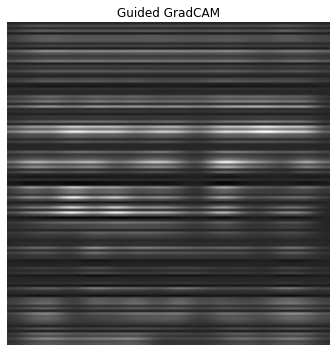

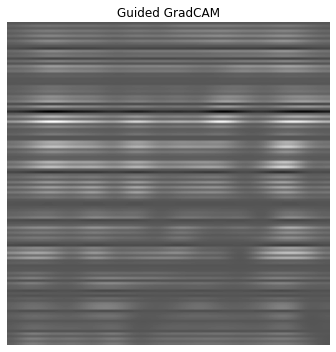

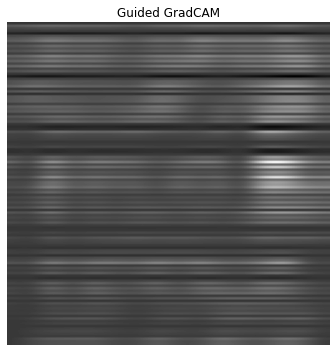

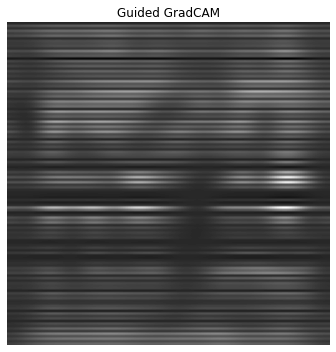

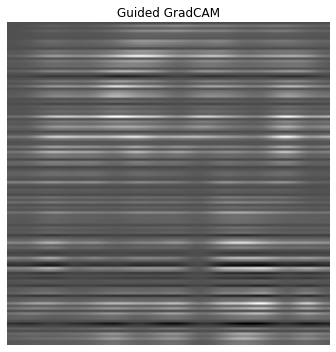

In [15]:
# Plot Guided-GCAM for 5 validation images
for i in range(len(gcam_list)):
    guided_gradcam(gcam_list[i], gbp_list[i], gbp_list[i][1])

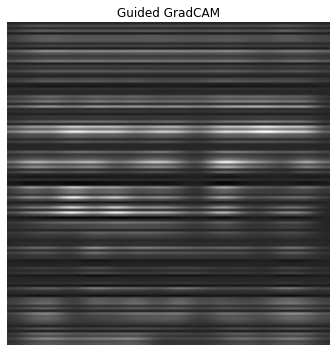

In [16]:
guided_gradcam(gcam101, gbp101, gbp101[1])